In [30]:
import calculate_wait_times
import pandas as pd
import os

HTML_OUTPUT_PATH = os.path.join("docs", "_includes", "2025")
trips = pd.read_parquet("output/trips_2025.parquet")
trips = trips.sort_values('start_time')

dataframe_export = trips.copy()
dataframe_export["start_time"] = dataframe_export["start_time"].dt.tz_localize('UTC')
dataframe_export["start_time"] = dataframe_export["start_time"].dt.tz_convert('US/Eastern')
dataframe_export["end_time"] = dataframe_export["end_time"].dt.tz_localize('UTC')
dataframe_export["end_time"] = dataframe_export["end_time"].dt.tz_convert('US/Eastern')

with open(os.path.join(HTML_OUTPUT_PATH, "dataframe_export.html"), 'w') as the_file:
# with open("fucking_work.html", 'w') as the_file:
    the_file.write('<div style="height: 500px; overflow: auto;">\n')
    dataframe_export.to_html(the_file, index=False)
    the_file.write('</div>\n')
    
early_bound = "2025-08-31 20:45"
late_bound = "2025-09-01 00:45"

wait_times = calculate_wait_times.generate_wait_times_df(trips, early_bound, late_bound)
wait_times

route_direction                time  wait_time
0     (901 State Fair - Hub, Fairgrounds-bound) 2025-08-31 20:45:00   0.000000
1     (901 State Fair - Hub, Fairgrounds-bound) 2025-08-31 20:46:00   1.000000
2     (901 State Fair - Hub, Fairgrounds-bound) 2025-08-31 20:47:00   2.000000
3     (901 State Fair - Hub, Fairgrounds-bound) 2025-08-31 20:48:00   0.983333
4     (901 State Fair - Hub, Fairgrounds-bound) 2025-08-31 20:49:00   1.983333
...                                         ...                 ...        ...
1448       (909 Destiny USA, Fairgrounds-bound) 2025-09-01 00:41:00   5.983333
1449       (909 Destiny USA, Fairgrounds-bound) 2025-09-01 00:42:00   0.983333
1450       (909 Destiny USA, Fairgrounds-bound) 2025-09-01 00:43:00   1.983333
1451       (909 Destiny USA, Fairgrounds-bound) 2025-09-01 00:44:00   2.983333
1452       (909 Destiny USA, Fairgrounds-bound) 2025-09-01 00:45:00   3.983333

[1453 rows x 3 columns]

In [25]:
wait_times.groupby('route_direction')['wait_time'].quantile(0.5)

route_direction
(901 State Fair - Hub, Fairgrounds-bound)         7.983333
(901 State Fair - Hub, hub-bound)                 7.983333
(907 Long Branch Park, Fairgrounds-bound)         5.000000
(907 Long Branch Park, Long Branch Park-bound)    4.983333
(909 Destiny USA, Destiny USA-bound)              2.983333
(909 Destiny USA, Fairgrounds-bound)              2.983333
Name: wait_time, dtype: float64

In [26]:
from datetime import date, datetime, timedelta

# for 2025 we need to exclude August 30 1143 through 1459 UTC
# and September 1 0517 through 1459 UTC
# Centro's data was missing during those periods.
def wait_times_for_date(trips_df, day):
    start_time = datetime(
        year=day.year, 
        month=day.month,
        day=day.day,
        hour=13, # 9 AM Eastern - they start going TO the fair at 8:45 but for now I'm only doing hours where BOTH directions are running
        minute=0,
        )
    end_time = start_time + timedelta(hours=11, minutes=45) # 8:45 PM Eastern
    return calculate_wait_times.generate_wait_times_df(trips_df, start_time, end_time)

def day_range(start_date, end_date):
    cur_date = start_date
    while cur_date <= end_date:
        yield cur_date
        cur_date += timedelta(days=1)

through_29th = pd.concat([wait_times_for_date(trips, fair_date) for fair_date in day_range(date(2025,8,20), date(2025,8,29))])
start_time_30th = datetime(
        year=2025, 
        month=8,
        day=30,
        hour=15,
        minute=00,
        )
end_time_30th = datetime(
        year=2025, 
        month=8,
        day=31,
        hour=0,
        minute=45,
        )
just_30th = calculate_wait_times.generate_wait_times_df(trips, start_time_30th, end_time_30th)
just_31st = wait_times_for_date(trips, date(2025,8,31))
start_time_1st = datetime(
        year=2025, 
        month=9,
        day=1,
        hour=15,
        minute=0,
        )
end_time_1st = datetime(
        year=2025, 
        month=9,
        day=2,
        hour=0,
        minute=45,
        )
just_1st = calculate_wait_times.generate_wait_times_df(trips, start_time_1st, end_time_1st)
wait_times = pd.concat([through_29th, just_30th, just_31st, just_1st])
wait_times 

route_direction                time  wait_time
0     (901 State Fair - Hub, Fairgrounds-bound) 2025-08-20 13:00:00   0.000000
1     (901 State Fair - Hub, Fairgrounds-bound) 2025-08-20 13:01:00   0.966667
2     (901 State Fair - Hub, Fairgrounds-bound) 2025-08-20 13:02:00   1.966667
3     (901 State Fair - Hub, Fairgrounds-bound) 2025-08-20 13:03:00   2.966667
4     (901 State Fair - Hub, Fairgrounds-bound) 2025-08-20 13:04:00   3.966667
...                                         ...                 ...        ...
3524       (909 Destiny USA, Fairgrounds-bound) 2025-09-02 00:41:00   9.983333
3525       (909 Destiny USA, Fairgrounds-bound) 2025-09-02 00:42:00  10.983333
3526       (909 Destiny USA, Fairgrounds-bound) 2025-09-02 00:43:00  11.983333
3527       (909 Destiny USA, Fairgrounds-bound) 2025-09-02 00:44:00  12.983333
3528       (909 Destiny USA, Fairgrounds-bound) 2025-09-02 00:45:00  13.983333

[53705 rows x 3 columns]

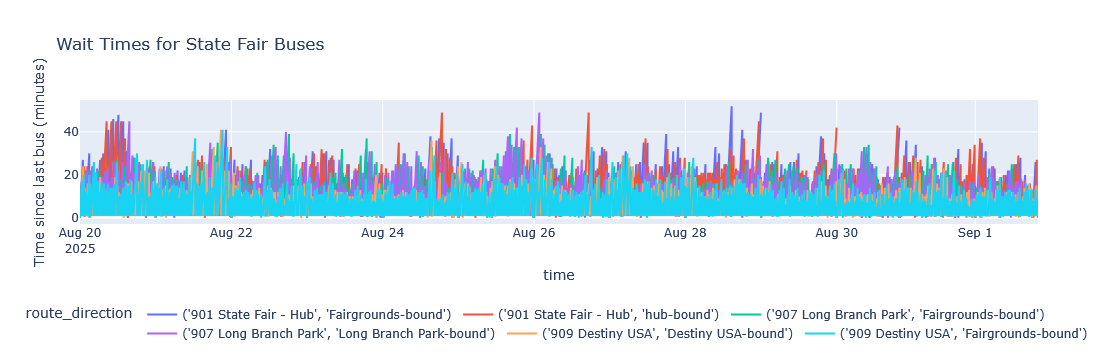

In [27]:
import plotly.express as px

to_graph = None
to_graph = wait_times.copy()
to_graph["time"] = to_graph["time"].dt.tz_localize('UTC')
to_graph["time"] = to_graph["time"].dt.tz_convert('US/Eastern')

interval = timedelta(hours=1)

rngBreaks=[]

for i in range(1, len(to_graph)):
        last_time = to_graph['time'].iloc[i-1]
        this_time = to_graph['time'].iloc[i]
        if this_time > last_time + interval:
            # print(f"Maybe we need a rangebreak between {last_time} and {this_time}")
            rngBreaks.append( dict( bounds=[last_time, this_time] ) )

fig = px.line(to_graph, render_mode='svg', x="time", y="wait_time", title='Wait Times for State Fair Buses', color='route_direction', labels={'wait_time': 'Time since last bus (minutes)'})
fig.update_xaxes( rangebreaks=rngBreaks) # , range=[xmin_stupid, xmax_stupid], )
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y= -1,  # Adjust this value to fine-tune vertical positioning
    xanchor="center",
    x=0.5
))
fig.write_html(os.path.join(HTML_OUTPUT_PATH, "plotly_export.html"))

#fig.update_xaxes(
#    rangebreaks=[dict(bounds=[17, 17], pattern="hour")],
#    range=[xmin_stupid, xmax_stupid],
#)
fig.show()

In [9]:
trips.groupby('route_name').size()

route_name
901 State Fair - Hub    1453
907 Long Branch Park    1748
909 Destiny USA         2695
dtype: int64

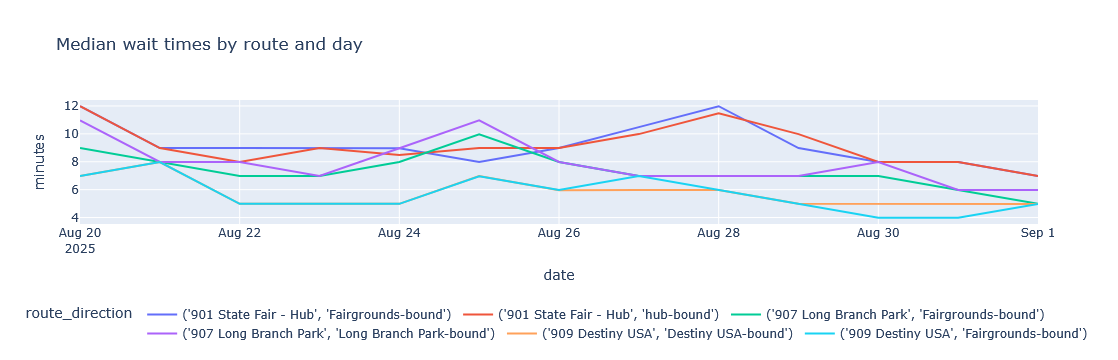

In [28]:
to_graph['date'] = to_graph['time'].dt.date
medians = to_graph.groupby(['date','route_direction'])['wait_time'].median().reset_index()
fig = px.line(medians, render_mode='svg', x="date", y="wait_time", title='Median wait times by route and day', color='route_direction', labels={'wait_time': 'minutes'})
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y= -1,  # Adjust this value to fine-tune vertical positioning
    xanchor="center",
    x=0.5
))
fig.write_html(f"{HTML_OUTPUT_PATH}/median_wait_times.html")
fig.show()

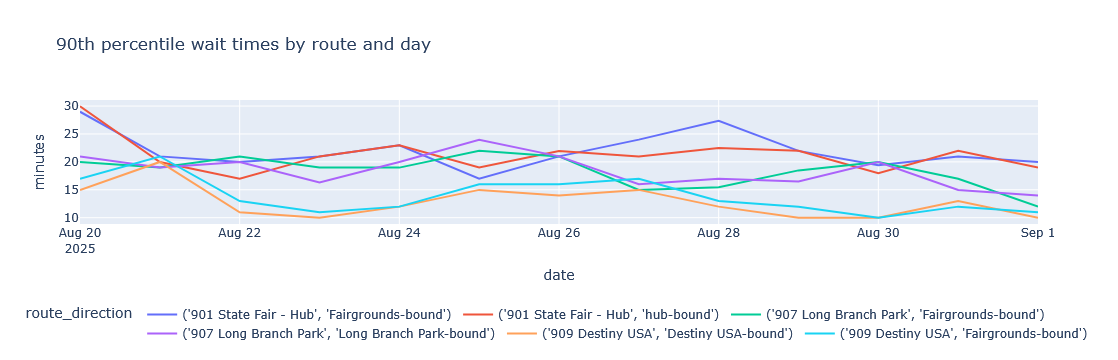

In [29]:
percentile90 = to_graph.groupby(['date','route_direction'])['wait_time'].quantile(0.9).reset_index()
fig = px.line(percentile90, render_mode='svg', x="date", y="wait_time", title='90th percentile wait times by route and day', color='route_direction', labels={'wait_time': 'minutes'})
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y= -1,  # Adjust this value to fine-tune vertical positioning
    xanchor="center",
    x=0.5
))
fig.write_html(f"{HTML_OUTPUT_PATH}/90p_wait_times.html")
fig.show()